In [502]:
import networks
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import SymLogNorm
import pandas as pd
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', DEVICE)
N_sensors=64
T_test = 16
include_motor = True


Using cuda


In [530]:
world = 5
import networks
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
angle_right_recording, angle_left_recording, step_intent_recording,\
          step_action_recording, sensor_recording,position_recording,orientation_recording\
            = networks.pull_from_file('for_gif_long_simulation_data_thin_skin.npz')#'big_simulation_data.npz')
angle_right_recording = np.expand_dims(angle_right_recording[1:,world],-1)#@ time of decision (intent of next layer)
angle_left_recording = np.expand_dims(angle_left_recording[1:,world],-1)#@ time of decision (intent of next layer)
step_intent_recording = np.expand_dims(step_intent_recording[1:,world],-1)#@ time of decision (intent of next layer)
step_action_recording = np.expand_dims(step_action_recording[:-1,world],-1)
or_recording = np.expand_dims(orientation_recording[:-1,world],-1) #@ time of decision (action of previous layer)
sensor_recording = np.expand_dims(sensor_recording[:,:-1,world],-1)#@ time of decision (sense of previous layer)
position_recording = np.expand_dims(position_recording[:,:-1,world],-1)
print('angle_right_recording', angle_right_recording.shape)
print('angle_left_recording', angle_left_recording.shape)
print('step_intent_recording', step_intent_recording.shape)
print('step_action_recording', step_action_recording.shape)
print('or_recording', or_recording.shape)
print('sensor_recording', sensor_recording.shape)
print('position_recording', position_recording.shape)
T_test = 16  # length of each subsequence
N_sensors = sensor_recording.shape[0]
N_trials = sensor_recording.shape[2]
factor_train = 0.8
angle_right_subsequences = networks.extract_subsequences(angle_right_recording, T_test)
angle_left_subsequences = networks.extract_subsequences(angle_left_recording, T_test)
step_intent_subsequences = networks.extract_subsequences(step_intent_recording, T_test)
step_action_subsequences = networks.extract_subsequences(step_action_recording, T_test)
or_subsequences = networks.extract_subsequences(or_recording, T_test)
sensor_subsequences = networks.extract_subsequences(sensor_recording, T_test,sensor=True)
position_subsequences = networks.extract_subsequences(position_recording, T_test,sensor=True)
print(step_action_subsequences.shape, sensor_subsequences.shape)
N_data_points = step_action_subsequences.shape[0]
N_data_train = round(N_data_points*factor_train)
x = np.concatenate([\
    sensor_subsequences, angle_left_subsequences, angle_right_subsequences,\
          step_intent_subsequences, step_action_subsequences], axis=-1)
y = np.concatenate([\
    sensor_subsequences, step_action_subsequences], axis=-1)
x = (x-np.mean(x,axis=0))/np.std(x,axis= 0)
print(np.min(x[:,:,:],axis=0),np.max(x[:,:,66:],axis=0))
rest_input = np.min(x[:,:,:],axis=0)
run_motor = np.max(x[:,:,66:],axis=0)
run_input = rest_input
run_input[:,66:] = run_motor
run_input = run_input[:-1,:]
rest_input = rest_input[:-1,:]
print('rest',rest_input.shape)
print('run',run_input.shape)
# plt.figure()
# plt.plot(range(y_val.shape[0]),y_val[:,-1,30])

angle_right_recording (19999, 1)
angle_left_recording (19999, 1)
step_intent_recording (19999, 1)
step_action_recording (19999, 1)
or_recording (19999, 1)
sensor_recording (64, 19999, 1)
position_recording (2, 19999, 1)
(19984, 16, 1) (19984, 16, 64)
[[-0.05710795 -0.05777309 -0.06044984 ... -0.7733992  -1.6758254
  -0.80843174]
 [-0.05710795 -0.05777309 -0.06044984 ... -0.77329373 -1.6758841
  -0.8083363 ]
 [-0.05710795 -0.05777309 -0.06044984 ... -0.77335596 -1.6758683
  -0.808318  ]
 ...
 [-0.05710794 -0.05777308 -0.06044984 ... -0.77343446 -1.6758727
  -0.80831647]
 [-0.05710794 -0.05777308 -0.06044984 ... -0.7734346  -1.6757137
  -0.8083011 ]
 [-0.05710794 -0.05777307 -0.06044983 ... -0.77344435 -1.6757181
  -0.8082863 ]] [[1.6690633 2.2370553]
 [1.6692555 2.2371356]
 [1.6690392 2.237315 ]
 [1.6689719 2.2374742]
 [1.6691829 2.2372162]
 [1.6691754 2.2376869]
 [1.6691433 2.2376454]
 [1.6691434 2.2376704]
 [1.6691988 2.2376707]
 [1.6691458 2.2378325]
 [1.6692498 2.2376454]
 [1.669257

load

In [523]:
final_sensor_weights = []
final_angle_intent_left_weights = []
final_angle_intent_right_weights = []
final_motor_intent_weights = []
penultimate_motor_intent_weights = []
final_motor_action_weights = []
final_motor_command_weights = []
final_sensor_sign = []
final_motor_command_sign = []
sensor_duration = []
motor_duration = []
sensor_integrativity = []
motor_integrativity = []
all_hidden_weights = []
all_hidden_biases = []
for run_n in range(10):
    filename = f"mleaves_temporal_prediction_model_thin_skin_run{run_n}.pth"
    model = networks.TemporalPrediction(hidden_units=128, L1=3.2e-6, device=DEVICE, N_sensors=N_sensors, T_test=T_test, include_motor=include_motor)
    model.load_state_dict(torch.load(filename))
    model.to(DEVICE)
    hidden_biases = model.hidden.bias.data
    hidden_biases = hidden_biases.view(128)
    all_hidden_biases.append(hidden_biases)
    hidden_weights = model.hidden.weight.data
    hidden_weights = hidden_weights.view(128, T_test-1, N_sensors+4)
    all_hidden_weights.append(hidden_weights)
    final_sensor_weights.append(hidden_weights[:, -1, 0:64])
    final_angle_intent_left_weights.append(hidden_weights[:, -1, 64])
    final_angle_intent_right_weights.append(hidden_weights[:, -1, 65])
    final_motor_intent_weights.append(hidden_weights[:, -1, 66])
    penultimate_motor_intent_weights.append(hidden_weights[:, -2, 66])
    final_motor_action_weights.append(hidden_weights[:, -1, 67])
    final_motor_command_weights.append(hidden_weights[:, -1, 64:])
    final_sensor_sign.append(1*(torch.sum(hidden_weights[:, :-1, 0:64], dim=1) + hidden_weights[:, -1, 0:64] < 0))
    final_motor_command_sign.append(1*(torch.sum(hidden_weights[:, :-1, 64:], dim=1) + hidden_weights[:, -1, 64:] < 0))
    sensor_duration.append(torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(hidden_weights[:, -1, 0:64]))
    motor_duration.append(torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(hidden_weights[:, -1, 64:]))
    sensor_integrativity.append(torch.sum(abs(hidden_weights[:, :, 0:64]), dim=1)/abs(torch.sum(hidden_weights[:, :, 0:64], dim=1)))
    motor_integrativity.append(torch.sum(abs(hidden_weights[:, :, 64:]), dim=1)/abs(torch.sum(hidden_weights[:, :, 64:], dim=1)))
final_sensor_weights = torch.cat(final_sensor_weights, dim=0)
final_angle_intent_left_weights = torch.cat(final_angle_intent_left_weights, dim=0)
final_angle_intent_right_weights = torch.cat(final_angle_intent_right_weights, dim=0)
final_motor_intent_weights = torch.cat(final_motor_intent_weights, dim=0)
penultimate_motor_intent_weights = torch.cat(penultimate_motor_intent_weights, dim=0)
final_motor_action_weights = torch.cat(final_motor_action_weights, dim=0)
final_motor_command_weights = torch.cat(final_motor_command_weights, dim=0)
final_sensor_sign = torch.cat(final_sensor_sign, dim=0)
final_motor_command_sign = torch.cat(final_motor_command_sign, dim=0)
sensor_duration = torch.cat(sensor_duration, dim=0)
motor_duration = torch.cat(motor_duration, dim=0)
sensor_integrativity = torch.cat(sensor_integrativity, dim=0)
motor_integrativity = torch.cat(motor_integrativity, dim=0)
all_hidden_weights = torch.cat(all_hidden_weights, dim=0)
all_hidden_biases = torch.cat(all_hidden_biases, dim=0)
print("Collected and concatenated weights from all runs.")
weights_all = all_hidden_weights.cpu().detach().numpy()
time_intent = weights_all[:,:,66]
time_action = weights_all[:,:,67]
time_turnl = weights_all[:,:,64]
time_turnr = weights_all[:,:,65]
print(weights_all.shape)
a =abs(weights_all)
sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,64:],axis = (1,2))
print(a[:,:,0:64].shape)

Collected and concatenated weights from all runs.
(1280, 15, 68)
(1280, 15, 64)


In [531]:
sensor_weights_all = weights_all[:,:,:64]
bias_plot = all_hidden_biases.cpu().detach().numpy()
f_weights_all = weights_all[:,:,:]
threshold_dead = 0.01*np.max(sensor_weights_all)
for i in range(f_weights_all.shape[0]):
    index = np.argmax(sensor_weights_all[i,-1,:]**2)
    if sensor_weights_all[i,-1,index] <-threshold_dead:
        sensor_weights_all[i,:,:] = -sensor_weights_all[i,:,:]
        f_weights_all[i,:,:] = -f_weights_all[i,:,:]



# sensory_inhib_time = np.sum(abs(sensor_weights_all*(sensor_weights_all<-threshold_dead)),axis=2)
# sensory_excite_time = np.sum(sensor_weights_all*(sensor_weights_all>threshold_dead),axis=2)
# sensory_dead_time = np.sum((abs(sensor_weights_all)<threshold_dead),axis=2)
# m_dead_time = np.sum((abs(m_weights_all)<threshold_dead),axis=2)
# sensory_inhib_time = np.mean(sensory_inhib_time,axis=0)
# sensory_excite_time = np.mean(sensory_excite_time,axis=0)
# sensory_dead_time = np.mean(sensory_dead_time,axis=0)
# m_dead_time = np.mean(m_dead_time,axis=0)
# plt.figure()
# plt.plot(np.linspace(15,1,15),(64-sensory_dead_time)/64,label='sensory')
# plt.plot(np.linspace(15,1,15),(4-m_dead_time)/4,label='motor')
# plt.legend()


hist/scatter plot function

In [524]:
def hist_plot_func(x,y,x_label,y_label,title,\
                   show_scatter = True,\
                    show_hist = True,x_bins = 16,y_bins = 16,\
                     show_median = False,x_smooth = 16):
    valid_indices = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_indices]
    y = y[valid_indices]
    plt.figure(figsize=(5,5))
    if show_hist == True:    
        H, xedges, yedges = np.histogram2d(x,y,bins=[x_bins, y_bins])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.imshow(H.T, extent=extent, origin='lower', aspect='auto',cmap='gray_r')
    if show_scatter==True:
        plt.scatter(x,y,marker='.',s=2,color = 'magenta')
    if show_median==True:
        df = pd.DataFrame({'x': x, 'y':y})
        median_y_per_x = df.groupby('x')['y'].mean().reset_index().rolling(window=x_smooth, center=True).mean()
        plt.plot(median_y_per_x['x'], median_y_per_x['y'],color='red')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


sensor field metrics

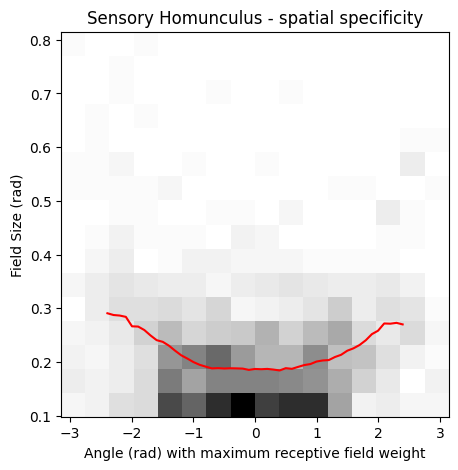

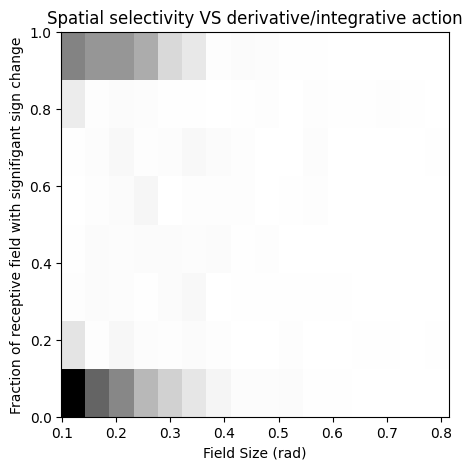

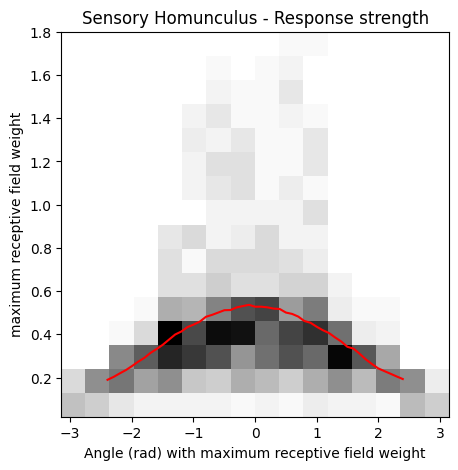

0.0


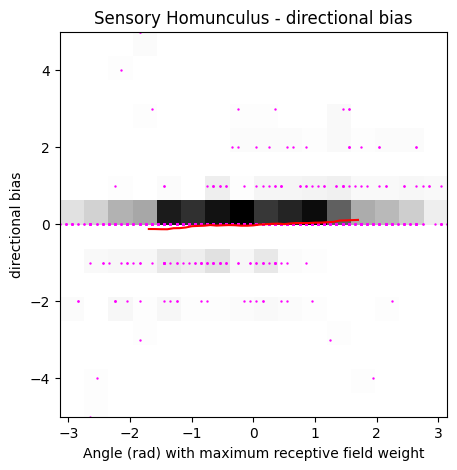

In [525]:
weights_plot = final_sensor_weights.cpu().detach().numpy()
weights_plot = np.transpose(weights_plot)
m_weights_plot = final_motor_command_weights.cpu().detach().numpy()
m_weights_plot = np.transpose(m_weights_plot)

duration_plot = sensor_duration.cpu().detach().numpy()
duration_plot = np.transpose(duration_plot)
int_plot = sensor_integrativity.cpu().detach().numpy()
int_plot = np.transpose(int_plot)
sign_plot = final_sensor_sign.cpu().detach().numpy()
sign_plot = np.transpose(sign_plot)
sensor_edges = np.linspace(-np.pi, np.pi, 64)
hit_plot = penultimate_motor_intent_weights.cpu().detach().numpy() - final_motor_action_weights.cpu().detach().numpy()
hit_plot = np.transpose(hit_plot)

area_weighted = np.empty((7,weights_plot.shape[1])) 
area_weighted[:,:] = np.nan
m_weighted = np.empty((4,weights_plot.shape[1])) 
m_weighted[:,:] = np.nan
summed_time_intent = np.empty(weights_plot.shape[1]) 
summed_time_action = np.empty(weights_plot.shape[1]) 
summed_time_turnl = np.empty(weights_plot.shape[1]) 
summed_time_turnr = np.empty(weights_plot.shape[1]) 
summed_time_prop = np.empty(weights_plot.shape[1]) 
summed_time_intent[:] = np.nan
summed_time_action[:] = np.nan
summed_time_turnl[:] = np.nan
summed_time_turnr[:] = np.nan
summed_time_prop[:] = np.nan

for i in range(weights_plot.shape[1]):  # Loop through each signal
    signal = weights_plot[:, i]

    abs_signal = signal**2
    abs_sig_ind = np.arange(len(abs_signal))  # Original indices
    interp_fact = 10
    abs_sig_ind_new = np.linspace(0, len(abs_signal) - 1, interp_fact * len(abs_signal))
    abs_sig_interp = np.interp(abs_sig_ind_new, abs_sig_ind, abs_signal)
    sp_ind = np.arange(len(sign_plot[:, i]))  # Original indices
    interp_fact = 10
    sp_ind_new = np.linspace(0, len(sign_plot[:, i]) - 1, interp_fact * len(sign_plot[:, i]))
    sp_interp = np.interp(sp_ind_new, sp_ind, sign_plot[:, i])

    weighted_min = max(abs_signal)*0.5
    if signal[np.argmax(abs_signal)]<0:
        signal = -signal
        m_weighted[:,i] = -m_weights_plot[:,i]
        summed_time_intent[i] = np.sum(-time_intent[i,:])
        summed_time_action[:] = np.sum(-time_action[i,:])
        summed_time_turnl[:] = np.sum(-time_turnl[i,:])
        summed_time_turnr[:] = np.sum(-time_turnr[i,:])
        summed_time_prop[:] = np.sum(time_action[i,1:]-time_action[i,:-1])

    else: 
        m_weighted[:,i] = m_weights_plot[:,i]
        summed_time_intent[i] = np.sum(time_intent[i,:])
        summed_time_action[:] = np.sum(time_action[i,:])
        summed_time_turnl[:] = np.sum(time_turnl[i,:])
        summed_time_turnr[:] = np.sum(time_turnr[i,:])
        summed_time_prop[:] = np.sum(-time_action[i,1:]+time_action[i,:-1])
    signed_min = signal[np.argmax(abs_signal)]*0.707
    area_weighted[1,i] = 2*np.pi*sum(abs_sig_interp>weighted_min)/abs_sig_interp.shape[0]#2*np.pi*sum(abs_signal>weighted_min)/signal.shape[0]
    area_weighted[0,i] = sensor_edges[np.argmax(abs_signal)]
    if signed_min>0:
        directional_bias =  sum((signal[:np.argmax(abs_signal)]<-signed_min))-sum((signal[np.argmax(abs_signal):]<-signed_min))
    else:
        directional_bias = sum((signal[:np.argmax(abs_signal)]>-signed_min))-sum((signal[np.argmax(abs_signal):]>-signed_min))
    area_weighted[6,i] = directional_bias
    area_weighted[2,i] = duration_plot[np.argmax(abs_signal), i]
    area_weighted[3,i] = sum(sp_interp[(abs_sig_interp>weighted_min)])/sum(abs_sig_interp>weighted_min)#sum(sign_plot[(abs_signal>weighted_min), i])/sum(abs_signal>weighted_min)
    area_weighted[4,i] = signal[np.argmax(abs_signal)]
    area_weighted[5,i] = int_plot[np.argmax(abs_signal), i]
    if abs(area_weighted[4,i]) < threshold_dead:
        area_weighted[:,i] = np.nan
m_weights_plot = m_weighted


hist_plot_func(area_weighted[0,:],area_weighted[1,:],'Angle (rad) with maximum receptive field weight','Field Size (rad)','Sensory Homunculus - spatial specificity',\
               show_hist=True,x_bins=16,y_bins=16,\
                show_scatter=False,show_median=True,x_smooth=16)
hist_plot_func(area_weighted[1,:],area_weighted[3,:],'Field Size (rad)','Fraction of receptive field with signifigant sign change'\
               ,'Spatial selectivity VS derivative/integrative action',\
               show_hist=True,x_bins=16,y_bins=8,\
                show_scatter=False)
hist_plot_func(area_weighted[0, :],area_weighted[4, :],'Angle (rad) with maximum receptive field weight','maximum receptive field weight'\
               ,'Sensory Homunculus - Response strength',\
               show_hist=True,x_bins=16,y_bins=16,\
                show_scatter=False,show_median=True,x_smooth=16)
print(np.nansum(area_weighted[4, :]<0)/(np.nansum(area_weighted[4, :]<0)+np.sum(area_weighted[4, :]>0)))



hist_plot_func(area_weighted[0, :],area_weighted[6, :],'Angle (rad) with maximum receptive field weight','directional bias'\
               ,'Sensory Homunculus - directional bias',\
               show_hist=True,x_bins=16,y_bins=16,\
                show_scatter=True,show_median=True,x_smooth=30)

In [507]:
np.sum(np.isnan(area_weighted[0,:]))

91

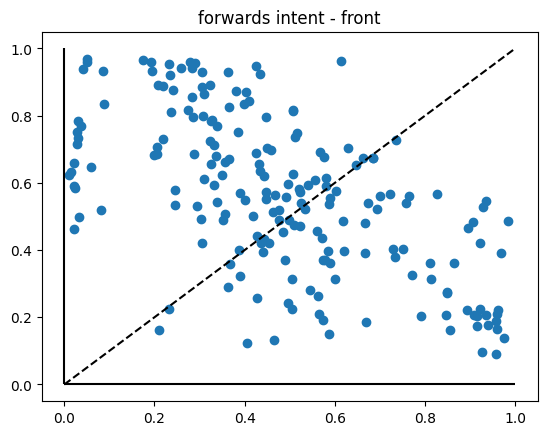

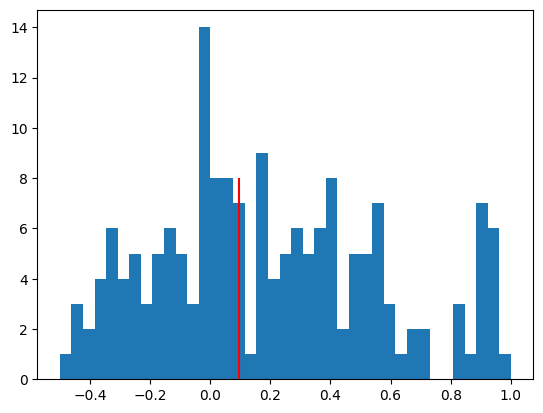

In [526]:
def sigmoid(x):
    y = np.exp(-x)+1
    y = y**-1
    return y



valid_indices = ((area_weighted[0,:]>-1*np.pi/4)&(area_weighted[0,:]<1*np.pi/4)\
                 &~np.isnan(area_weighted[0,:])& (abs(summed_time_intent)>0.01))
rest2 = bias_plot[valid_indices]
weight2 = summed_time_intent[valid_indices]
run2 = sigmoid(rest2 + 1.6694242*weight2)
rest2 = sigmoid(rest2 + -1.6759535*weight2)
plt.figure()
plt.scatter(rest2,run2)#abs(bias_plot[valid_indices]),abs(bias_plot[valid_indices]+m_weights_plot[3,valid_indices]))
plt.hlines(0,xmin=0,xmax=1,color = 'black')
plt.vlines(0,ymin=0,ymax=1,color = 'black')
plt.plot([0,1],[0,1],color='black',linestyle='dashed')
plt.title('forwards intent - front')


#print('fraction sensory motor',sum(abs(m_weights_plot[3,valid_indices])>0.01)/m_weights_plot[3,valid_indices].shape)


plt.figure()
plt.hist((run2-rest2)/(run2+rest2),np.linspace(-0.5,1,40))
plt.vlines(np.mean((run2-rest2)/(run2+rest2)),ymin=0,ymax = 8,color = 'red')

receptive fields

/tmp/ipykernel_223740/95521911.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm


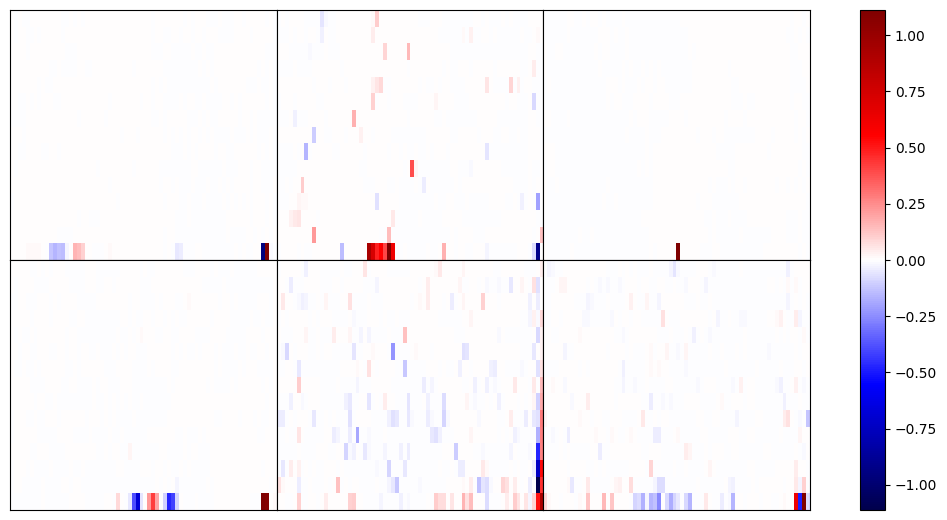

/tmp/ipykernel_223740/95521911.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm


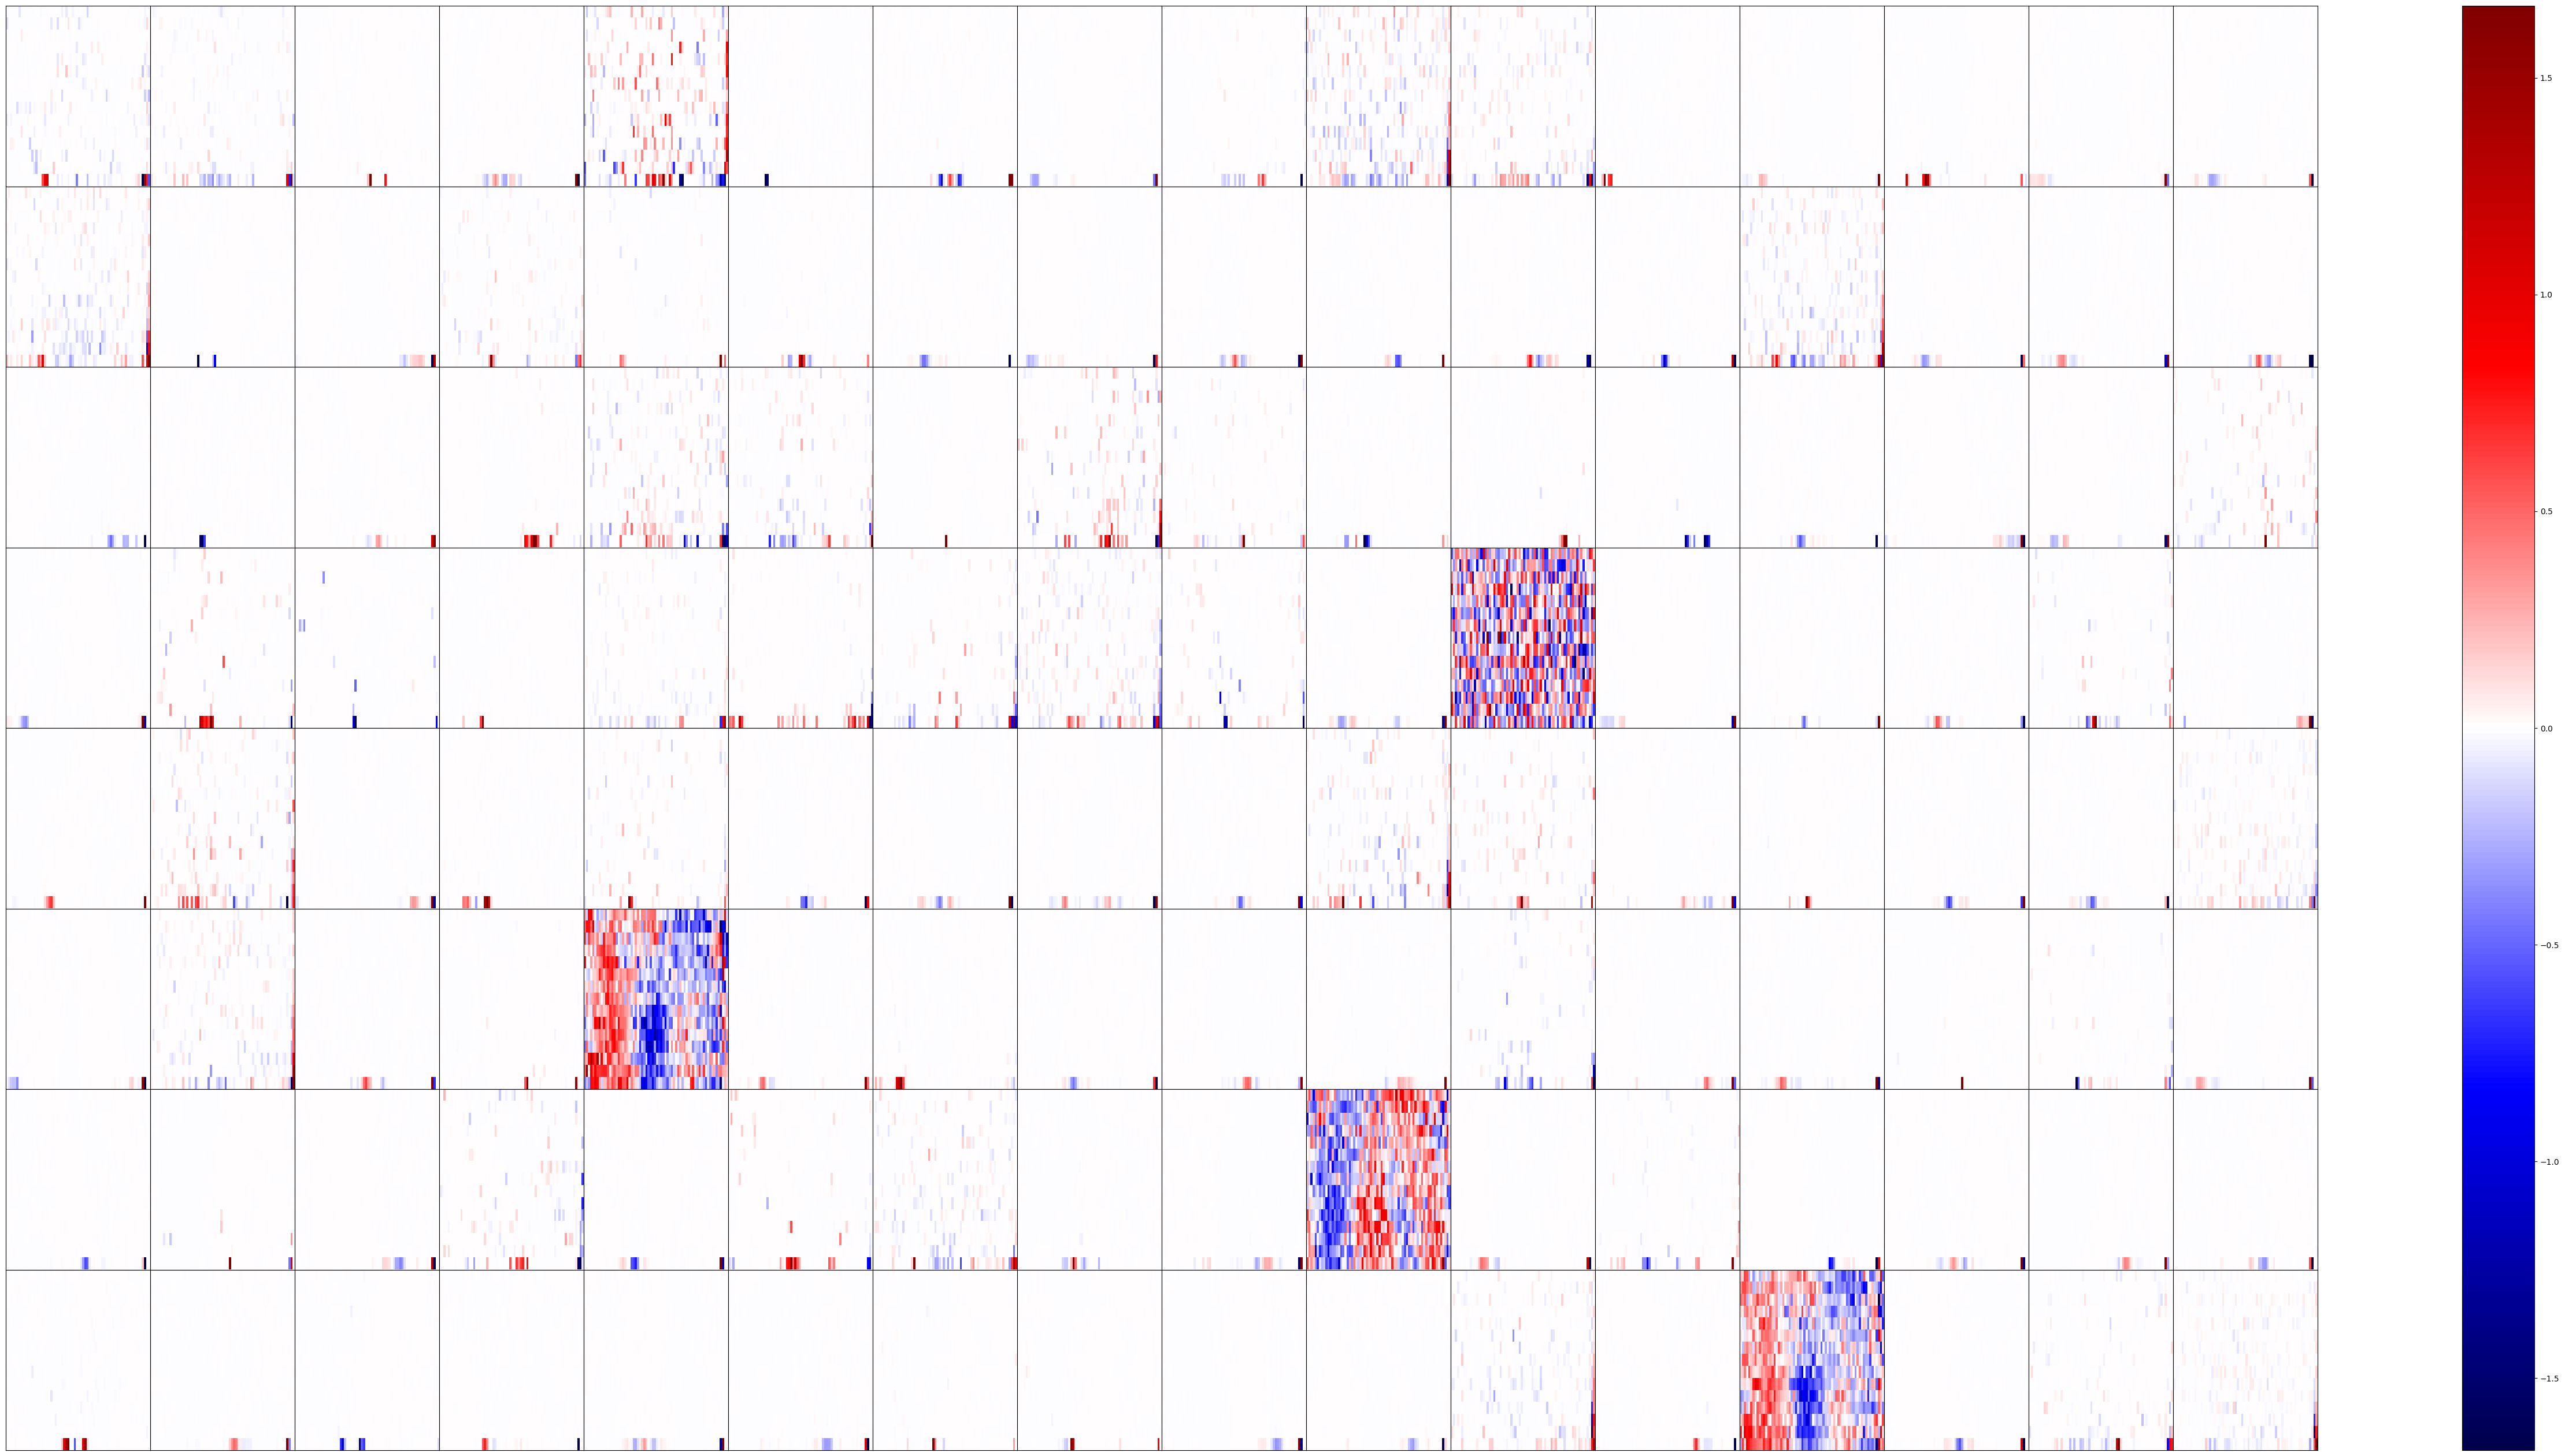

In [509]:
sensor_edges = np.linspace(-np.pi, np.pi, 64)
cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm
global_scale =False
vmax = torch.max(abs(hidden_weights))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # Adjust figsize as needed
indexs = [16*2+14,16*3+1,16*2+6,6,16*7+10,1]
for i in range(2):
    for j in range(3):
        index = indexs[i * 3 + j]  # Correct indexing over a flat list of weights        
        if include_motor == True:
            #image_matrix = h0.reshape((T_test - 1,N_sensors+4))
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors+4).cpu()
        else:
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors).cpu()
        ax = axes[i, j]
        if global_scale == False:
            vmax = torch.max(abs(image_matrix))
            vmin = -vmax
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        im = ax.imshow(image_matrix[:,:], cmap=cmap, aspect='auto', norm=norm)        
        ax.set_xticks([])
        ax.set_yticks([])
    

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
plt.show()

sensor_edges = np.linspace(-np.pi, np.pi, 64)
cmap = cm.get_cmap('seismic')  # 'bwr' stands for Blue-White-Red but will adjust to Blue-Black-Red using norm
global_scale =False
vmax = torch.max(abs(hidden_weights))
vmin = -vmax
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axes = plt.subplots(8, 16, figsize=(50, 25))  # Adjust figsize as needed
indexs = [16*2+14,16*3+1,16*2+6,6,16*7+10,1]
for i in range(8):
    for j in range(16):
        index = i * 16 + j  # Correct indexing over a flat list of weights        
        if include_motor == True:
            #image_matrix = h0.reshape((T_test - 1,N_sensors+4))
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors+4).cpu()
        else:
            image_matrix = hidden_weights[index,:,:].view(T_test-1,N_sensors).cpu()
        ax = axes[i, j]
        if global_scale == False:
            vmax = torch.max(abs(image_matrix))
            vmin = -vmax
            norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
            # norm = SymLogNorm(linthresh=0.1, linscale=1,
            #                                   vmin=vmin, vmax=vmax)
        im = ax.imshow(image_matrix[:,:], cmap=cmap, aspect='auto', norm=norm)        
        ax.set_xticks([])
        ax.set_yticks([])
    

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
plt.show()





motor-motor relations

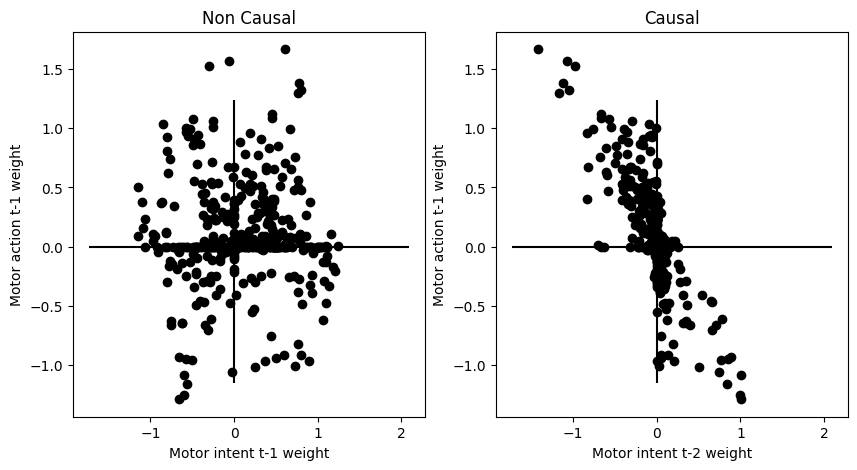

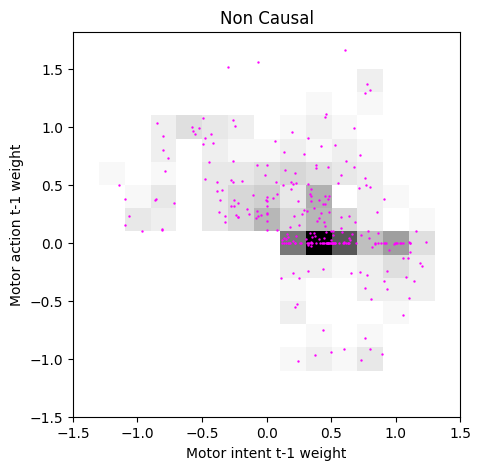

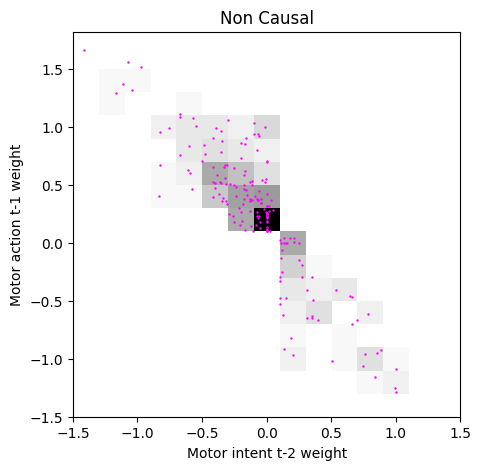

fraction sensorymotor 0.9350758853288365


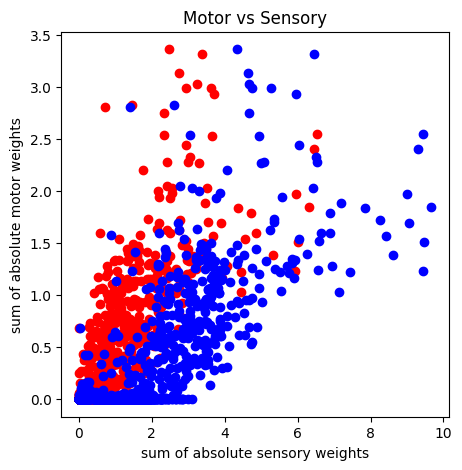

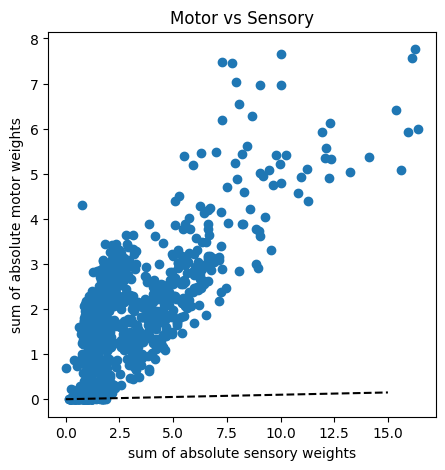

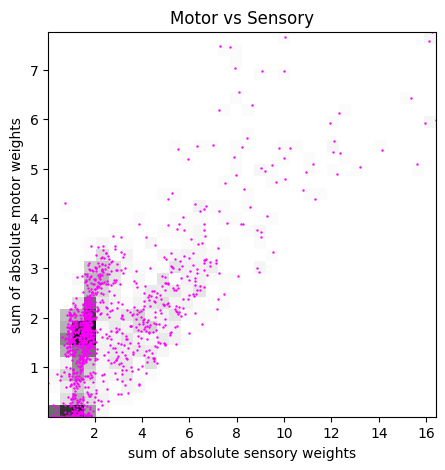

fraction sensorymotor all 0.9350758853288365
fraction sensorymotor 0.8919831223628693
fraction sensorymotor 0.46015625


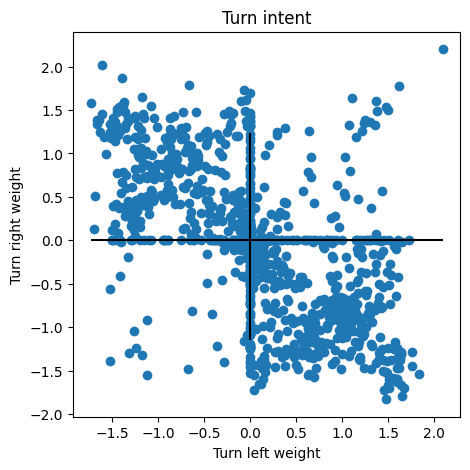

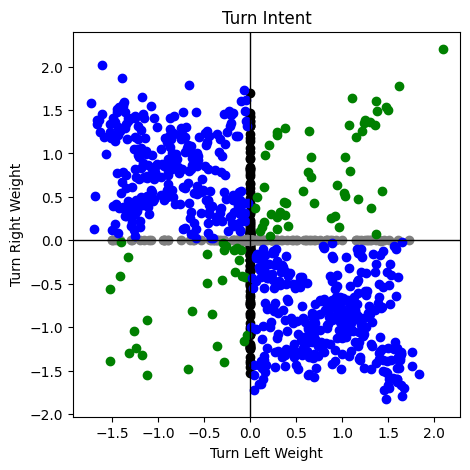

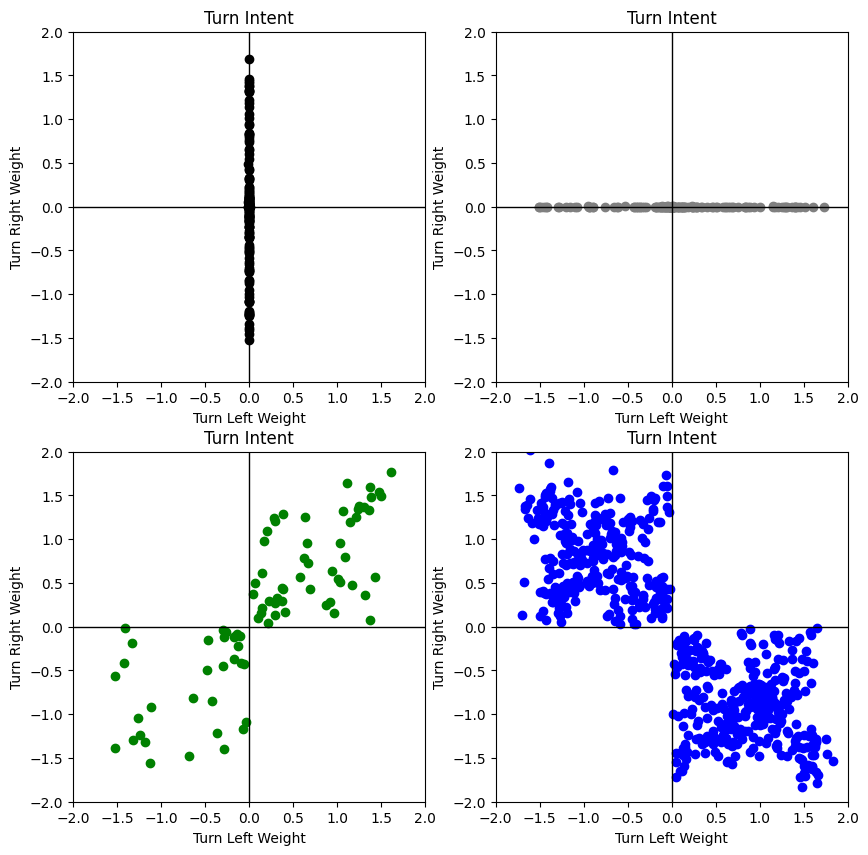

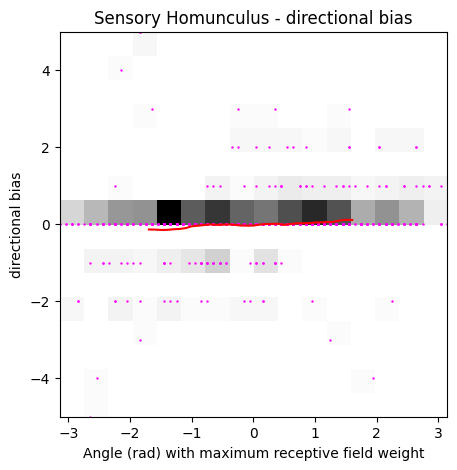

(611,)


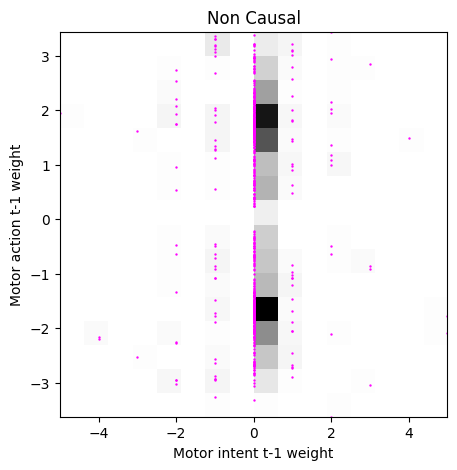

Text(0.5, 1.0, 'Turn VS forwards intents')

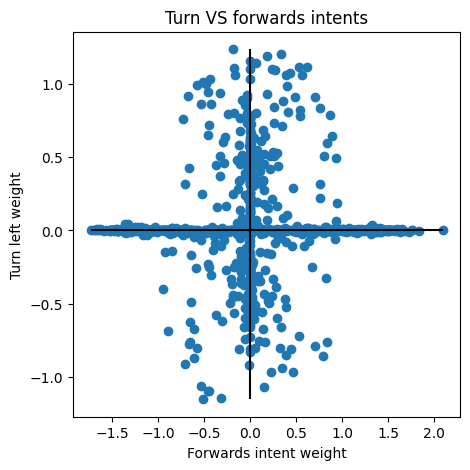

In [519]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(final_motor_intent_weights.cpu().detach().numpy(),final_motor_action_weights.cpu().detach().numpy(), color='black')
plt.hlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]),color = 'black')
plt.vlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]),color = 'black')
plt.title('Non Causal')
plt.xlabel('Motor intent t-1 weight')
plt.ylabel('Motor action t-1 weight')
plt.subplot(1,2,2)
plt.scatter(penultimate_motor_intent_weights.cpu().detach().numpy(),final_motor_action_weights.cpu().detach().numpy(), color='black')
plt.hlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]),color = 'black')
plt.vlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]),color = 'black')
plt.title('Causal')
plt.xlabel('Motor intent t-2 weight')
plt.ylabel('Motor action t-1 weight')



xhist = final_motor_intent_weights.cpu().detach().numpy()
yhist = final_motor_action_weights.cpu().detach().numpy()
is_ok = ((xhist>0.1)|(yhist>0.1))
xhist = xhist[is_ok]
yhist = yhist[is_ok]

hist_plot_func(xhist,yhist,\
               'Motor intent t-1 weight','Motor action t-1 weight'\
               ,'Non Causal',\
               show_hist=True,x_bins=np.linspace(-1.5,1.5,16),y_bins=np.linspace(-1.5,1.5,16),\
                show_scatter=True)

xhist = penultimate_motor_intent_weights.cpu().detach().numpy()
yhist = final_motor_action_weights.cpu().detach().numpy()
is_ok = ((xhist>0.1)|(yhist>0.1))
xhist = xhist[is_ok]
yhist = yhist[is_ok]
hist_plot_func(xhist,yhist,\
               'Motor intent t-2 weight','Motor action t-1 weight'\
               ,'Non Causal',\
               show_hist=True,x_bins=np.linspace(-1.5,1.5,16),y_bins=np.linspace(-1.5,1.5,16),\
                show_scatter=True)


sum_senserear = np.sum(np.concatenate((a[:,:,0:15],a[:,:,48:64]),axis = 2),axis = (1,2))
sum_sensefront = np.sum(a[:,:,16:48],axis = (1,2))
sum_motor = np.sum(a[:,:,66],axis = (1))

plt.figure(figsize=(5,5))
plt.scatter(sum_senserear,sum_motor,color ='red')
plt.scatter(sum_sensefront,sum_motor,color ='blue')
# plt.plot([0,15],[0,15],linestyle = 'dashed',color = 'black')
plt.title('Motor vs Sensory')
plt.xlabel('sum of absolute sensory weights')
plt.ylabel('sum of absolute motor weights')

sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,64:],axis = (1,2))
is_ok = ((sum_sense>0.1)|(sum_motor>0.1))
sum_sense = sum_sense[is_ok]
sum_motor = sum_motor[is_ok]
print('fraction sensorymotor',sum((sum_motor>0.01*sum_sense))/sum_sense.shape[0])
plt.figure(figsize=(5,5))
plt.scatter(sum_sense,sum_motor)
plt.plot([0,15],[0,0.15],linestyle = 'dashed',color = 'black')
plt.title('Motor vs Sensory')
plt.xlabel('sum of absolute sensory weights')
plt.ylabel('sum of absolute motor weights')

hist_plot_func(sum_sense,sum_motor,\
               'sum of absolute sensory weights','sum of absolute motor weights'\
               ,'Motor vs Sensory',\
               show_hist=True,x_bins=32,y_bins=32,\
                show_scatter=True)


sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,64:],axis = (1,2))
is_ok = ((sum_sense>0.1)|(sum_motor>0.1))
sum_sense = sum_sense[is_ok]
sum_motor = sum_motor[is_ok]
print('fraction sensorymotor all',sum((sum_motor>0.01*sum_sense))/sum_sense.shape[0])

sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,64:66],axis = (1,2))
is_ok = ((sum_sense>0.1)|(sum_motor>0.1))
sum_sense = sum_sense[is_ok]
sum_motor = sum_motor[is_ok]
print('fraction sensorymotor',sum((sum_motor>0.01*sum_sense))/sum_sense.shape[0])

sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,66],axis = (1))
print('fraction sensorymotor',sum((sum_motor>0.01*sum_sense))/sum_sense.shape[0])


plt.figure(figsize=(5,5))
plt.scatter(final_angle_intent_left_weights.cpu().detach().numpy(),final_angle_intent_right_weights.cpu().detach().numpy())
plt.hlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]),color = 'black')
plt.vlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]),color = 'black')
plt.title('Turn intent')
plt.xlabel('Turn left weight')
plt.ylabel('Turn right weight')


# Assuming final_angle_intent_left_weights and final_angle_intent_right_weights are your data
x = final_angle_intent_left_weights.cpu().detach().numpy()
y = final_angle_intent_right_weights.cpu().detach().numpy()

# Create a figure and axis for the plot
plt.figure(figsize=(5,5))

# Define colors for each group
y_axis_indices = np.where(np.abs(x) <= 0.01)
x_axis_indices = np.where(np.abs(y) <= 0.01)
tr_bl_indices = np.where(x * y > 0.01)
tl_br_indices = np.where(x * y < -0.01)

plt.scatter(x[y_axis_indices], y[y_axis_indices], color='black')
plt.scatter(x[x_axis_indices], y[x_axis_indices], color='gray')
plt.scatter(x[tr_bl_indices], y[tr_bl_indices], color='green')
plt.scatter(x[tl_br_indices], y[tl_br_indices], color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Turn Intent')
plt.xlabel('Turn Left Weight')
plt.ylabel('Turn Right Weight')
plt.show()


# Create a figure and axis for the plot
plt.figure(figsize=(10,10))

# Define colors for each group
y_axis_indices = np.where(np.abs(x) <= 0.01)
x_axis_indices = np.where(np.abs(y) <= 0.01)
tr_bl_indices = np.where(x * y > 0.01)
tl_br_indices = np.where(x * y < -0.01)
plt.subplot(2,2,1)
plt.scatter(x[y_axis_indices], y[y_axis_indices], color='black')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Turn Intent')
plt.xlabel('Turn Left Weight')
plt.ylabel('Turn Right Weight')
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.subplot(2,2,2)
plt.scatter(x[x_axis_indices], y[x_axis_indices], color='gray')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Turn Intent')
plt.xlabel('Turn Left Weight')
plt.ylabel('Turn Right Weight')
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.subplot(2,2,3)
plt.scatter(x[tr_bl_indices], y[tr_bl_indices], color='green')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Turn Intent')
plt.xlabel('Turn Left Weight')
plt.ylabel('Turn Right Weight')
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.subplot(2,2,4)
plt.scatter(x[tl_br_indices], y[tl_br_indices], color='blue')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Turn Intent')
plt.xlabel('Turn Left Weight')
plt.ylabel('Turn Right Weight')
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()
b = [1,2,3,4,5]


hist_plot_func(area_weighted[0, tl_br_indices],area_weighted[6, tl_br_indices],'Angle (rad) with maximum receptive field weight','directional bias'\
               ,'Sensory Homunculus - directional bias',\
               show_hist=True,x_bins=16,y_bins=16,\
                show_scatter=True,show_median=True,x_smooth=30)
turn_diff = final_angle_intent_left_weights-final_angle_intent_right_weights
print(area_weighted[6,tl_br_indices].squeeze().shape)
hist_plot_func(area_weighted[6,tl_br_indices].squeeze(),turn_diff[tl_br_indices].cpu().detach().numpy(),\
               'Motor intent t-1 weight','Motor action t-1 weight'\
               ,'Non Causal',\
               show_hist=True,x_bins=16,y_bins=16,\
                show_scatter=True)



plt.figure(figsize=(5,5))

plt.scatter(m_weights_plot.transpose()[:,0],m_weights_plot.transpose()[:,2])
plt.hlines(0,min(m_weights_plot.transpose()[:,0]),max(m_weights_plot.transpose()[:,0]),color = 'black')
plt.vlines(0,min(m_weights_plot.transpose()[:,2]),max(m_weights_plot.transpose()[:,2]),color = 'black')
plt.ylabel('Turn left weight')
plt.xlabel('Forwards intent weight')
plt.title('Turn VS forwards intents')

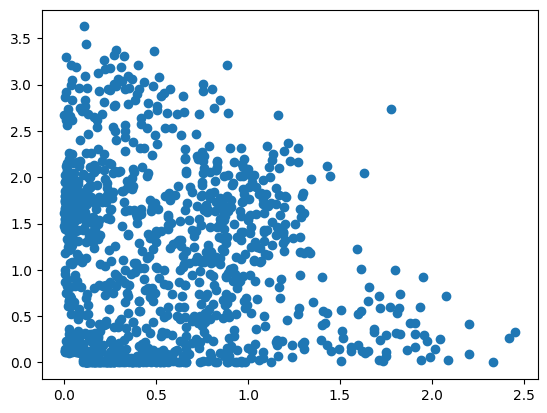

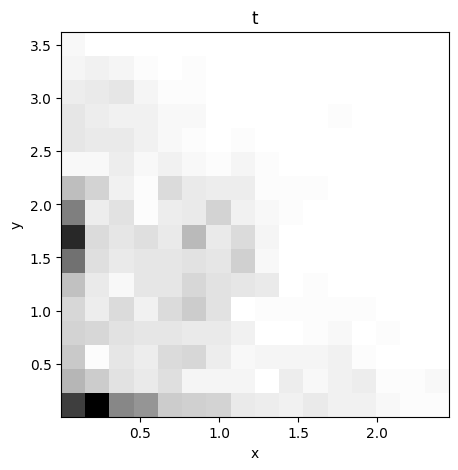

In [511]:
b =weights_all

sum_sense = abs(np.sum(b[:,:,8:24],axis = (1,2))-np.sum(b[:,:,40:48],axis = (1,2)))
sum_motor = abs(np.sum(b[:,:,64],axis = (1))-np.sum(b[:,:,65],axis = (1)))
is_ok = ((abs(sum_sense)>0.1)|(abs(sum_motor)>0.1))
plt.figure()
plt.scatter(sum_sense[is_ok], sum_motor[is_ok])
hist_plot_func(sum_sense[is_ok], sum_motor[is_ok],'x','y','t',show_scatter=False)

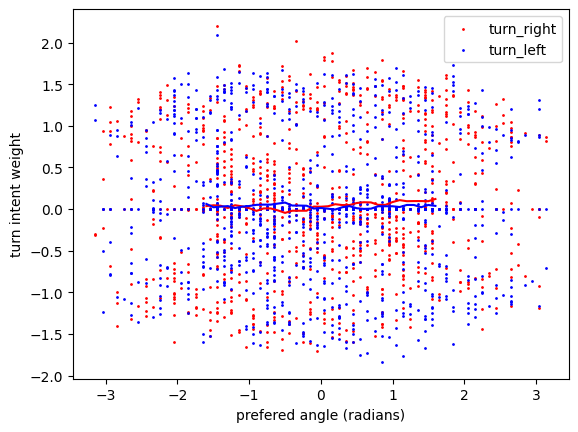

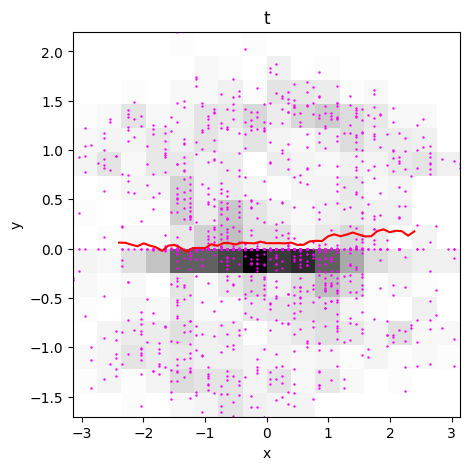

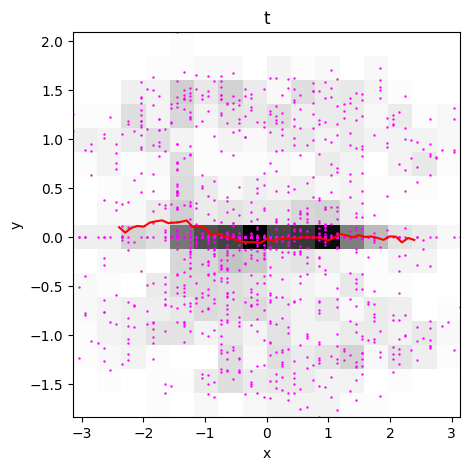

In [512]:
plt.figure()
valid_indices  = ~np.isnan(area_weighted[0, :])
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[1,valid_indices],color = 'red',label = 'turn_right',s=1)
plt.scatter(area_weighted[0, valid_indices],m_weights_plot[0,valid_indices],color = 'blue',label = 'turn_left',s=1)
df = pd.DataFrame({'x': area_weighted[0, valid_indices], 'y':m_weights_plot[1,valid_indices]})
median_y_per_x = df.groupby('x')['y'].median().reset_index().rolling(window=32, center=True).mean()
plt.plot(median_y_per_x['x'], median_y_per_x['y'],color='red')
df = pd.DataFrame({'x': area_weighted[0, valid_indices], 'y':m_weights_plot[0,valid_indices]})
median_y_per_x = df.groupby('x')['y'].median().reset_index().rolling(window=32, center=True).mean()
plt.plot(median_y_per_x['x'], median_y_per_x['y'],color='blue')
plt.xlabel('prefered angle (radians)')
plt.ylabel('turn intent weight')
plt.legend()


hist_plot_func(area_weighted[0, valid_indices],m_weights_plot[1,valid_indices],'x','y','t'\
               ,show_median=True, x_smooth=16)
hist_plot_func(area_weighted[0, valid_indices],m_weights_plot[0,valid_indices],'x','y','t'\
               ,show_median=True, x_smooth=16)

In [513]:
def calculate_means(x_data, y_data):
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    positive_x_indices = x_data > 0
    x_mean_positive = np.mean(x_data[positive_x_indices])
    y_mean_positive = np.mean(y_data[positive_x_indices])
    negative_x_indices = x_data < 0
    x_mean_negative = np.mean(x_data[negative_x_indices])
    y_mean_negative = np.mean(y_data[negative_x_indices])
    x_vals = [x_mean_negative, x_mean_positive]
    y_vals = [y_mean_negative, y_mean_positive]
    return x_vals, y_vals

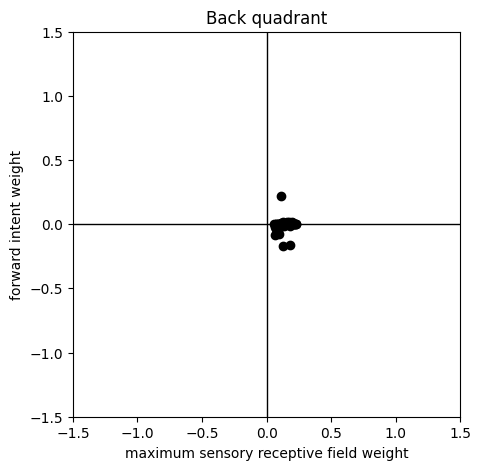

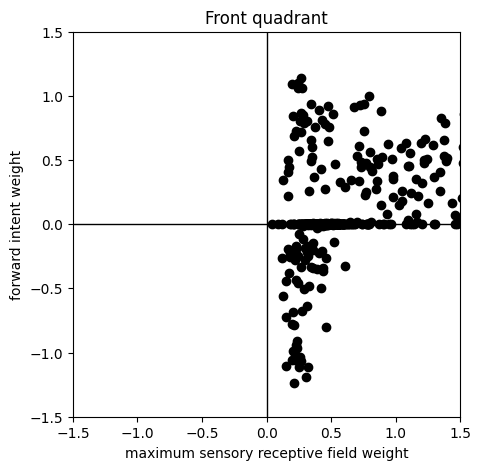

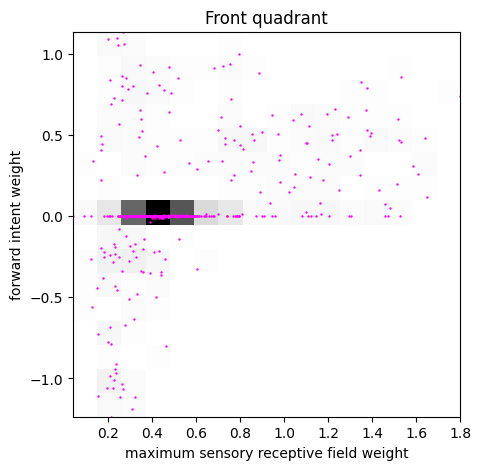

(-1.5, 1.5)

<Figure size 500x500 with 0 Axes>

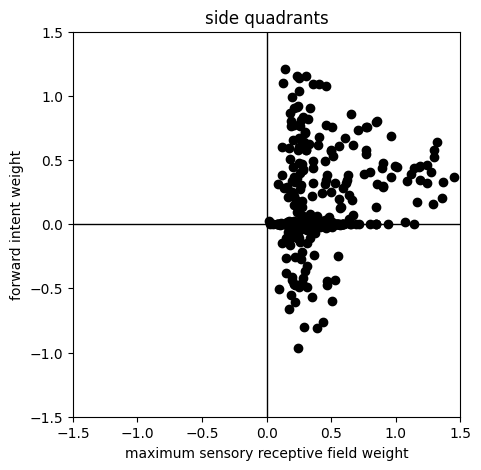

In [514]:
sum_sense = np.sum(a[:,:,0:64],axis = (1,2))
sum_motor = np.sum(a[:,:,66],axis = (1))
sm_rel = (sum_motor>0.01*sum_sense)


valid_indices = ((area_weighted[0, :]<-3*np.pi/4) | (area_weighted[0, :]>3*np.pi/4))#&sm_rel
plt.figure(figsize = (5,5))
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], color='black')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title('Back quadrant')
plt.xlabel('maximum sensory receptive field weight')
plt.ylabel('forward intent weight')


valid_indices = (area_weighted[0, :]<1*np.pi/4) & (area_weighted[0, :]>-1*np.pi/4)#&sm_rel

plt.figure(figsize = (5,5))
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], color='black')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('Front quadrant')
plt.xlabel('maximum sensory receptive field weight')
plt.ylabel('forward intent weight')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])

hist_plot_func(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices],\
               'maximum sensory receptive field weight'\
                ,'forward intent weight',
                'Front quadrant')



plt.figure(figsize=(5,5))
valid_indices = ~((area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)|((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4)))
plt.figure(figsize = (5,5))
plt.scatter(area_weighted[4, valid_indices],m_weights_plot[2,valid_indices], color='black')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title('side quadrants')
plt.xlabel('maximum sensory receptive field weight')
plt.ylabel('forward intent weight')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])

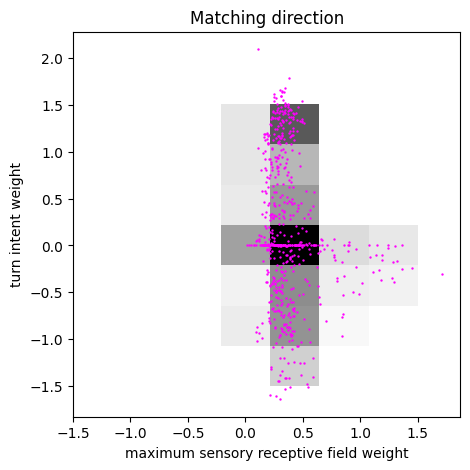

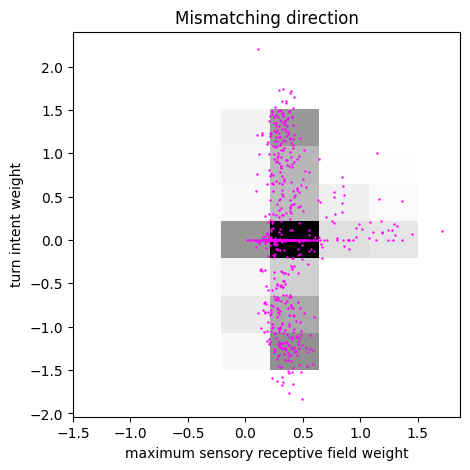

<Figure size 500x500 with 0 Axes>

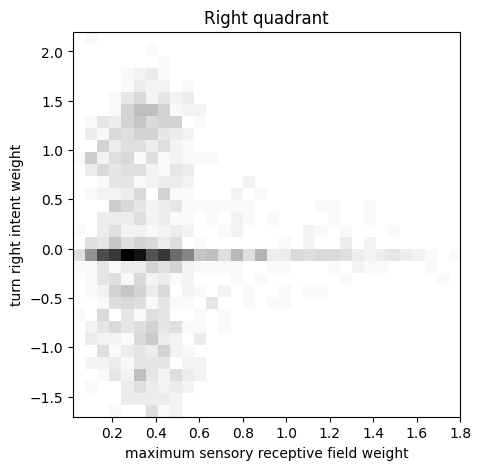

<Figure size 500x500 with 0 Axes>

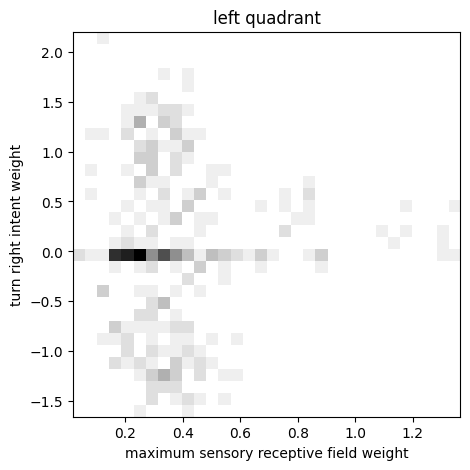

<Figure size 500x500 with 0 Axes>

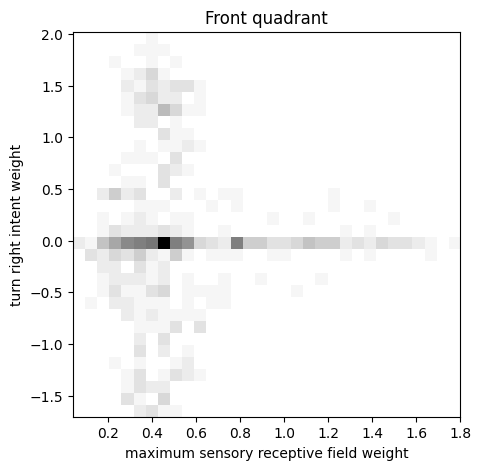

<Figure size 500x500 with 0 Axes>

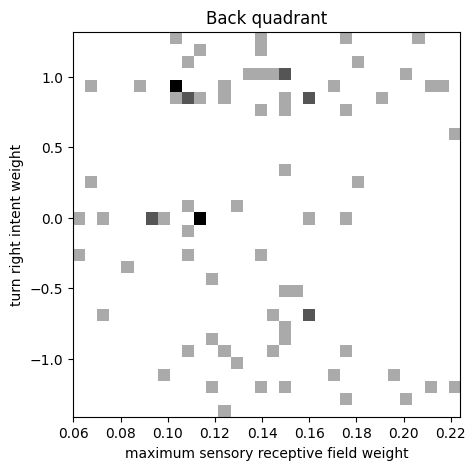

In [515]:
x = final_angle_intent_left_weights.cpu().detach().numpy()
y = final_angle_intent_right_weights.cpu().detach().numpy()
y_axis_indices = (np.abs(x) <= 0.01)
x_axis_indices = (np.abs(y) <= 0.01)
tr_bl_indices = (x * y > 0.01)
tl_br_indices = (x * y < -0.01)

valid_indices = (area_weighted[0, :]> 1*np.pi/4) & (area_weighted[0, :]<3*np.pi/4)
congruent_intent_side_I = m_weights_plot[1,valid_indices]
congruent_intent_side_S  = area_weighted[4, valid_indices]
valid_indices = (area_weighted[0, :]< - np.pi/4)  & (area_weighted[0, :]>-3*np.pi/4)
congruent_intent_side_I = np.concatenate((congruent_intent_side_I,m_weights_plot[0,valid_indices]),axis=0)
congruent_intent_side_S  = np.concatenate((congruent_intent_side_S,area_weighted[4, valid_indices]),axis=0)
valid_indices = (area_weighted[0, :]> 1*np.pi/4) & (area_weighted[0, :]<3*np.pi/4)
anti_intent_side_I = m_weights_plot[0,valid_indices]
anti_intent_side_S  = area_weighted[4, valid_indices]
valid_indices = (area_weighted[0, :]< - np.pi/4)  & (area_weighted[0, :]>-3*np.pi/4)
anti_intent_side_I = np.concatenate((anti_intent_side_I,m_weights_plot[1,valid_indices]),axis=0)
anti_intent_side_S  = np.concatenate((anti_intent_side_S,area_weighted[4, valid_indices]),axis=0)


hist_plot_func(congruent_intent_side_S,congruent_intent_side_I,\
               'maximum sensory receptive field weight','turn intent weight','Matching direction',\
               show_hist=True,x_bins=np.linspace(-1.5,1.5,8),y_bins=np.linspace(-1.5,1.5,8),\
                show_scatter=True,show_median=False,x_smooth=200)

hist_plot_func(anti_intent_side_S,anti_intent_side_I,\
               'maximum sensory receptive field weight','turn intent weight','Mismatching direction',\
               show_hist=True,x_bins=np.linspace(-1.5,1.5,8),y_bins=np.linspace(-1.5,1.5,8),\
                show_scatter=True,show_median=False,x_smooth=200)





plt.figure(figsize=(5,5))
valid_indices = (area_weighted[0, :]> -4*np.pi/4)# & (area_weighted[0, :]<3*np.pi/4)
hist_plot_func(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],'maximum sensory receptive field weight','turn right intent weight','Right quadrant',\
               show_hist=True,x_bins=32,y_bins=32,\
                show_scatter=False)

plt.figure(figsize=(5,5))
valid_indices = (area_weighted[0, :]< - np.pi/4)  & (area_weighted[0, :]>-3*np.pi/4)
hist_plot_func(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],'maximum sensory receptive field weight','turn right intent weight','left quadrant',\
               show_hist=True,x_bins=32,y_bins=32,\
                show_scatter=False)


(area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)
plt.figure(figsize=(5,5))
valid_indices = (area_weighted[0, :]<np.pi/4) & (area_weighted[0, :]>-np.pi/4)# & tr_bl_indices
hist_plot_func(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],'maximum sensory receptive field weight','turn right intent weight','Front quadrant',\
               show_hist=True,x_bins=32,y_bins=32,\
                show_scatter=False)

plt.figure(figsize=(5,5))
valid_indices = ((area_weighted[0, :]>3*np.pi/4) | (area_weighted[0, :]<-3*np.pi/4))# & tr_bl_indices
hist_plot_func(area_weighted[4, valid_indices],m_weights_plot[1,valid_indices],'maximum sensory receptive field weight','turn right intent weight','Back quadrant',\
               show_hist=True,x_bins=32,y_bins=32,\
                show_scatter=False)
